# Lab 5: More about Attention Mechanisms and Transformer Architecture

This comprehensive Jupyter Notebook lab sheet covers the fundamental concepts and practical implementations of attention mechanisms and transformer models. The lab is designed to provide hands-on experience with both theoretical understanding and practical coding exercises using PyTorch.



## 0. Setup

This setup section prepares the notebook environment for the attention mechanisms and transformer experiments. It ensures all necessary dependencies are available and configures the visualization environment.

The setup includes:

• Installing dependencies if needed (transformers, torch, matplotlib, seaborn, PIL)

• Importing essential libraries for neural networks, plotting, and image processing  

• Setting matplotlib and seaborn styles for consistent high-quality visualizations

• Configuring GPU support if available (recommended for faster execution)

In [3]:
# Setup: installs and centralized imports
import torch.nn.functional as F
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as PILImage
from transformers import (AutoTokenizer, AutoModel,
                          ViTImageProcessor, ViTForImageClassification)
# Global settings
plt.rcParams['figure.dpi'] = 120
sns.set_theme(style='whitegrid')

## 1. Soft Attention vs Hard Attention Implementation

### 1.1 Understanding Attention Mechanisms

Attention mechanisms help neural networks focus on relevant parts of input data, mimicking human cognitive attention. There are two primary types of attention mechanisms that differ in how they process and select information:

**Soft Attention:**
• Computes weighted averages of all input elements
• Differentiable and can be trained with backpropagation
• Assigns attention weights to all positions simultaneously
• More commonly used in practice due to training advantages

**Hard Attention:**
• Makes discrete decisions about which parts to attend to
• Non-differentiable, requires reinforcement learning techniques
• Selects specific positions rather than weighting all
• More interpretable but harder to train

### 1.2 Basic Soft Attention Implementation
Translate the math behind soft attention (weighted average over all positions) into runnable PyTorch code.

Learning: How attention scores are produced and normalised

In [4]:
# Missing variables that need to be defined first
batch_size = 1
seq_len = 5  # for the example sentence "I love learning Artificial Intelligence" (without CLS/SEP)
hidden_dim = 512
example_text = "I love learning Artificial Intelligence"

# Define simple soft attention implementation first
class SoftAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.scorer = nn.Linear(dim, 1)

    def forward(self, x):
        scores = self.scorer(x).squeeze(-1)  # (batch, seq_len)
        weights = F.softmax(scores, dim=-1)  # normalize
        context = (x * weights.unsqueeze(-1)).sum(1)  # weighted sum
        return context, weights, scores

# Fake encoder outputs (random features per word)
enc_outputs = torch.randn(batch_size, seq_len, hidden_dim)

# Create soft attention and get outputs
soft_attn = SoftAttention(hidden_dim)
ctx_s, attention_weights, raw_s = soft_attn(enc_outputs)

print("\nSoft-attention details")
print(f"Context vector shape: {ctx_s.shape}")
print("Attention weights:", attention_weights[0].tolist())
print(f"Raw scores: {raw_s[0].tolist()}")

# Extract words for later use
words = example_text.split()
print(f"\nWords: {words}")
print(f"Expected {len(words)} words, got {seq_len} positions")

# Store for visualization - will be updated by hard attention
hard_attention_weights = attention_weights


Soft-attention details
Context vector shape: torch.Size([1, 512])
Attention weights: [0.14797654747962952, 0.18683890998363495, 0.29821130633354187, 0.16447971761226654, 0.20249341428279877]
Raw scores: [-0.008565999567508698, 0.22462689876556396, 0.6921824216842651, 0.09716736525297165, 0.30508744716644287]

Words: ['I', 'love', 'learning', 'Artificial', 'Intelligence']
Expected 5 words, got 5 positions


## 1.3 Hard Attention Implementation
Contrast soft attention with a discrete, sampling-based variant that selects a single position (Gumbel-Softmax).
Learning: The trade-off between interpretability (hard) and ease of optimisation (soft).

In [5]:
# ─────────────────── Section 1.3  Hard Attention (verbose) ────────────────────
class HardAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.scorer = nn.Linear(dim, 1)

    def forward(self, x, temp=1.0):
        scores  = self.scorer(x).squeeze(-1)
        gumbel  = -torch.log(-torch.log(torch.rand_like(scores)))
        logits  = (scores + gumbel) / temp
        hard    = F.one_hot(logits.argmax(-1), scores.size(-1)).float()
        ctx     = (x * hard.unsqueeze(-1)).sum(1)
        return ctx, hard, scores

hard_attn = HardAttention(hidden_dim)
ctx_h, hard_mask, raw_h = hard_attn(enc_outputs)

idx = hard_mask.argmax(-1).item()
print("\nHard-attention details")
print(f"Chosen token index : {idx}  →  '{words[idx]}'")
print("Hard mask          :", hard_mask[0].tolist())
print("Context vector shape:", ctx_h.shape,
      "← identical to the chosen word’s embedding\n")



Hard-attention details
Chosen token index : 4  →  'Intelligence'
Hard mask          : [0.0, 0.0, 0.0, 0.0, 1.0]
Context vector shape: torch.Size([1, 512]) ← identical to the chosen word’s embedding



## 1.4 Comparison and Visualization
The key differences between soft and hard attention become evident when comparing their attention weight distributions.

* Soft Attention = weighted average. Every token whispers, some louder than others.
* Hard Attention = winner-takes-all. Only one token talks; the rest stay silent.

Plot both weight patterns side-by-side to make differences tangible.

Learning: Visually recognise the “spread-out” probabilities of soft attention versus the “one-hot” spikes of hard attention.

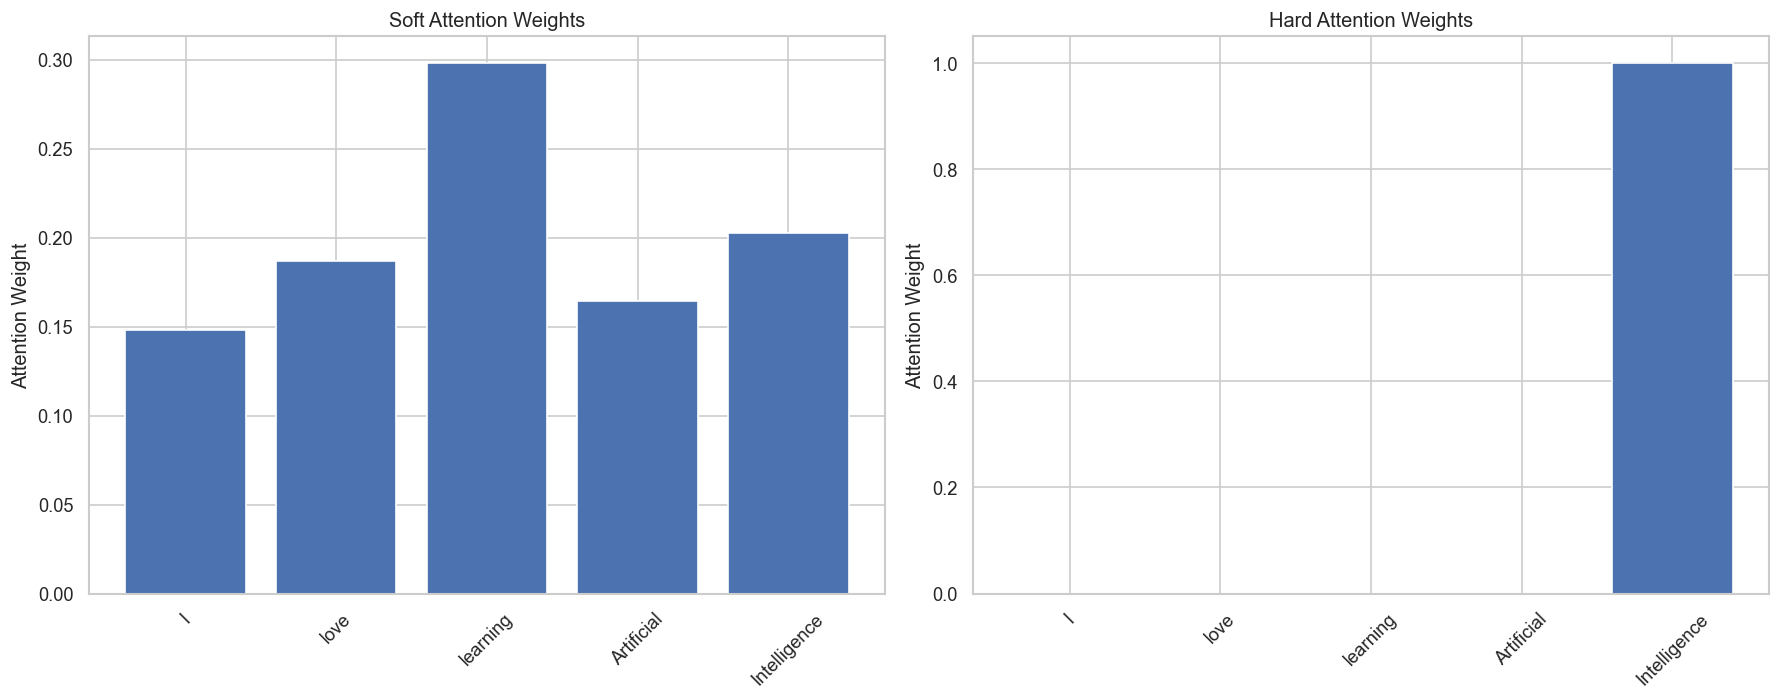

In [8]:
def visualize_attention_comparison(words, soft_weights, hard_weights):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    # Soft attention visualization
    ax1.bar(words, soft_weights.detach().numpy()[0])
    ax1.set_title('Soft Attention Weights')
    ax1.set_ylabel('Attention Weight')
    ax1.tick_params(axis='x', rotation=45)
    # Hard attention visualization
    ax2.bar(words, hard_weights.detach().numpy()[0])
    ax2.set_title('Hard Attention Weights')
    ax2.set_ylabel('Attention Weight')
    ax2.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

# Update hard_attention_weights from the hard attention output
hard_attention_weights = hard_mask  # Use the hard mask from the previous cell

# Visualize the comparison
words = example_text.split()
visualize_attention_comparison(words, attention_weights, hard_attention_weights)

## 2 Using nn.MultiheadAttention

### 2.1 Understanding Multi-Head Attention
Multi-head attention allows models to jointly attend to information from different representation subspaces. This mechanism is fundamental to the transformer architecture and enables the model to focus on different aspects of the input simultaneously.

### 2.2 Basic Multihead-Attention Implementation

Move from hand-written single-head code to PyTorch’s built-in multi-head layer.

Learning: How multiple heads let the model attend to different relational cues in parallel.

In [11]:
# ─────────────────────────────────────────────────────────────
#  Section 2.2 : Multi-Head Attention with detailed inspection
# ─────────────────────────────────────────────────────────────
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

# -------------------------------------------------------------
# 1) Get real token embeddings for the same demo sentence
# -------------------------------------------------------------
sentence   = globals().get("example_text",
                           "I love learning Artificial Intelligence")
model_name     = "bert-base-uncased"
tokenizer      = AutoTokenizer.from_pretrained(model_name)
bert_model     = AutoModel.from_pretrained(model_name)

with torch.no_grad():
    tokens = tokenizer(sentence, return_tensors="pt")
    # last_hidden_state → (batch, seq_len, 768)
    embeddings = bert_model(**tokens).last_hidden_state

print("Tokens :", tokenizer.convert_ids_to_tokens(tokens["input_ids"][0]))
print("Embeddings shape:", embeddings.shape, "\n")

# -------------------------------------------------------------
# 2) Shrink dim → 512 so we can split into 8 heads of 64 dims
# -------------------------------------------------------------
proj = nn.Linear(embeddings.size(-1), 512, bias=False)
embeddings_512 = proj(embeddings)                        # (1, seq_len, 512)

# -------------------------------------------------------------
# 3) Run multi-head self-attention (8 heads × 64 dims)
#    average_attn_weights=False keeps per-head matrices
# -------------------------------------------------------------
mha = nn.MultiheadAttention(
        embed_dim=512,
        num_heads=8,
        batch_first=True)

attn_output, attn_weights = mha(
        embeddings_512, embeddings_512, embeddings_512,
        average_attn_weights=False)

# -------------------------------------------------------------
# 4) Print detailed, labelled output
# -------------------------------------------------------------
print("attn_output shape :", attn_output.shape,
      "→ new embeddings for each token")
print("attn_weights shape:", attn_weights.shape,
      "→ (batch, heads, query_len, key_len)\n")

# Pretty-print the first head’s attention matrix
head0 = attn_weights[0, 0]        # (query_len, key_len)
tok_list = tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])

print("Head-0 attention matrix (rows=queries, cols=keys):")
print("     " + "  ".join(f"{t:>12}" for t in tok_list))
for i, row in enumerate(head0):
    values = "  ".join(f"{w.item():10.4f}" for w in row)
    print(f"{tok_list[i]:>12}  {values}")

# -------------------------------------------------------------
# 5) Quick summary: how much each head focuses on the CLS token
# -------------------------------------------------------------
cls_focus = attn_weights[:, :, 0, :].mean(dim=-1).squeeze(0)  # (heads,)
print("\nAverage focus on [CLS] per head:", cls_focus.tolist())

Tokens : ['[CLS]', 'i', 'love', 'learning', 'artificial', 'intelligence', '[SEP]']
Embeddings shape: torch.Size([1, 7, 768]) 

attn_output shape : torch.Size([1, 7, 512]) → new embeddings for each token
attn_weights shape: torch.Size([1, 8, 7, 7]) → (batch, heads, query_len, key_len)

Head-0 attention matrix (rows=queries, cols=keys):
            [CLS]             i          love      learning    artificial  intelligence         [SEP]
       [CLS]      0.1411      0.1486      0.1535      0.1435      0.1355      0.1325      0.1453
           i      0.1407      0.1473      0.1509      0.1418      0.1417      0.1378      0.1399
        love      0.1492      0.1405      0.1424      0.1411      0.1374      0.1377      0.1517
    learning      0.1561      0.1542      0.1438      0.1365      0.1307      0.1340      0.1447
  artificial      0.1419      0.1548      0.1507      0.1404      0.1355      0.1343      0.1423
intelligence      0.1431      0.1557      0.1475      0.1399      0.1344    

### 2.3 Self-Attention Block Implementation

Wrap multi-head attention, residual connections, layer norm and feed-forward network into one reusable module.

Learning: The internal anatomy of a Transformer encoder layer.

In [12]:
# ───────────────── Section 2.3 vs 2.2  Demonstration ─────────────────
import torch, torch.nn as nn, torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import pandas as pd

# 1)  Get real embeddings for the lab sentence
text        = globals().get("example_text", "I love learning Artificial Intelligence")
tok         = AutoTokenizer.from_pretrained("bert-base-uncased")
bert        = AutoModel.from_pretrained("bert-base-uncased")
with torch.no_grad():
    emb768  = bert(**tok(text, return_tensors="pt")).last_hidden_state          # (1,L,768)

# project to 512 dims so we can split into 8 heads of 64 dims
proj        = nn.Linear(768, 512, bias=False)
emb512      = proj(emb768)

# 2) 2.2  — raw multi-head attention
mha         = nn.MultiheadAttention(512, 8, batch_first=True)
raw_out, _  = mha(emb512, emb512, emb512, average_attn_weights=False)           # (1,L,512)

# 3) 2.3  — self-attention block (residual + LN + FFN)
class SelfBlock(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        self.mha  = nn.MultiheadAttention(d, h, batch_first=True)
        self.ln1  = nn.LayerNorm(d)
        self.ffn  = nn.Sequential(nn.Linear(d, 4*d), nn.GELU(), nn.Linear(4*d, d))
        self.ln2  = nn.LayerNorm(d)
    def forward(self, x):
        y, _ = self.mha(x, x, x, average_attn_weights=False)
        x    = self.ln1(x + y)          # residual 1
        z    = self.ln2(x + self.ffn(x))# residual 2
        return z

block       = SelfBlock(512, 8)
block_out   = block(emb512)                                                    # (1,L,512)

# ── NEW: keep & preview the actual output of the 2.3 block ──
saved_block_out = block_out.detach().cpu()          # (1, seq_len, 512)
print("\n[2.3] block_out kept as 'saved_block_out'")
print("Shape :", saved_block_out.shape)

# Peek at the first token (CLS) – first 8 dimensions only
print("\nFirst 8 dims of CLS token after 2.3:")
print(saved_block_out[0, 0, :8])


# 4)  Simple quantitative comparison
def avg_pairwise_cos(x):                       # average cosine similarity across all token pairs
    x = x.squeeze(0)                           # (L,512)
    sims = [F.cosine_similarity(x[i], x[j], dim=0)
            for i in range(len(x)) for j in range(i+1, len(x))]
    return torch.stack(sims).mean().item()

metrics = pd.DataFrame({
    "Metric"                  : ["Std-dev of features",
                                 "Avg pairwise cosine similarity"],
    "Raw MHA (2.2)"           : [ raw_out.std().item(),     avg_pairwise_cos(raw_out)  ],
    "SelfAttn Block (2.3)"    : [ block_out.std().item(),   avg_pairwise_cos(block_out)]
}).set_index("Metric").style.format("{:.4f}")

display(metrics)

# 5)  Explanation line printed for quick reading
print("\nInterpretation:")
if avg_pairwise_cos(block_out) < avg_pairwise_cos(raw_out):
    print("  • Lower cosine similarity → tokens became *more specialised* after the full block.")
else:
    print("  • Higher similarity → tokens share context more evenly (depends on sentence).")
print("  • Higher feature std-dev usually means richer, higher-contrast representations.")



[2.3] block_out kept as 'saved_block_out'
Shape : torch.Size([1, 7, 512])

First 8 dims of CLS token after 2.3:
tensor([ 1.8126,  1.8742, -0.0702, -0.4052, -0.9425, -0.0967,  0.4412,  1.5683])


,Raw MHA (2.2),SelfAttn Block (2.3)
Metric,,
Std-dev of features,0.0782,1.0001
Avg pairwise cosine similarity,0.9997,0.3426



Interpretation:
  • Lower cosine similarity → tokens became *more specialised* after the full block.
  • Higher feature std-dev usually means richer, higher-contrast representations.


###  2.4 Attention Visualization

Render the query-key heat-map (per head or averaged) for the toy sentence.

Learning: How to read attention matrices and spot patterns such as self-loops or long-range links.

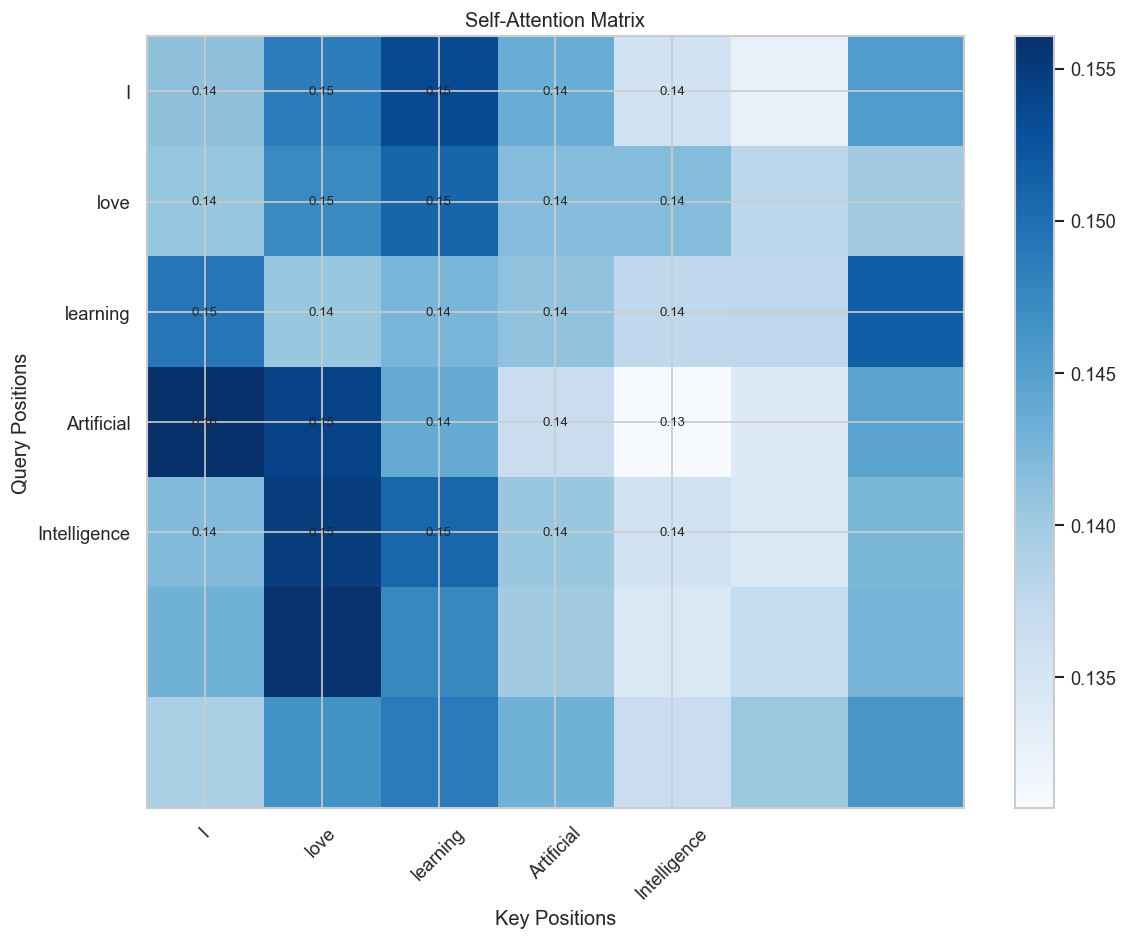

In [13]:
def visualize_attention_matrix(attention_weights, words, title="Attention Matrix"):
    # Take the first head of the first batch
    attn_matrix = attention_weights[0, 0].detach().numpy()
    plt.figure(figsize=(10, 8))
    plt.imshow(attn_matrix, cmap='Blues', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Key Positions')
    plt.ylabel('Query Positions')

    # Set tick labels
    plt.xticks(range(len(words)), words, rotation=45)
    plt.yticks(range(len(words)), words)

    # Add text annotations
    for i in range(len(words)):
        for j in range(len(words)):
            plt.text(j, i, f'{attn_matrix[i, j]:.2f}',
                    ha='center', va='center', fontsize=8)
    plt.tight_layout()
    plt.show()

# Visualize self-attention - using attn_weights from 2.2
visualize_attention_matrix(attn_weights, words, "Self-Attention Matrix")

## 2.5 Training and Backpropagation on Attention

This section demonstrates, with a tiny synthetic example, how a simple attention mechanism adapts during a short training run: we initialize, train briefly, and compare attention weights before and after to see how focus shifts toward task-relevant positions.


=== Section 2.5: Training and Backpropagation on Attention ===
Demonstrating how attention weights evolve during training...

Created synthetic dataset:
- Input shape: torch.Size([20, 5, 16])
- Target shape: torch.Size([20, 1])
- Task: Predict if average of last 2 positions > 0

Starting training loop...
Epoch  0: Loss = 0.7349
Epoch  5: Loss = 0.6121
Epoch 10: Loss = 0.4525
Epoch 15: Loss = 0.2868
Epoch 20: Loss = 0.1438
Epoch 25: Loss = 0.0498
Epoch 30: Loss = 0.0166
Epoch 35: Loss = 0.0069
Epoch 40: Loss = 0.0033
Epoch 45: Loss = 0.0017
Epoch 50: Loss = 0.0011
Epoch 55: Loss = 0.0008
Epoch 60: Loss = 0.0006
Epoch 65: Loss = 0.0005
Epoch 70: Loss = 0.0004
Epoch 75: Loss = 0.0004
Epoch 80: Loss = 0.0004
Epoch 85: Loss = 0.0003
Epoch 90: Loss = 0.0003
Epoch 95: Loss = 0.0003

Training completed! Final loss: 0.0003
Loss improvement: 0.7349 → 0.0003



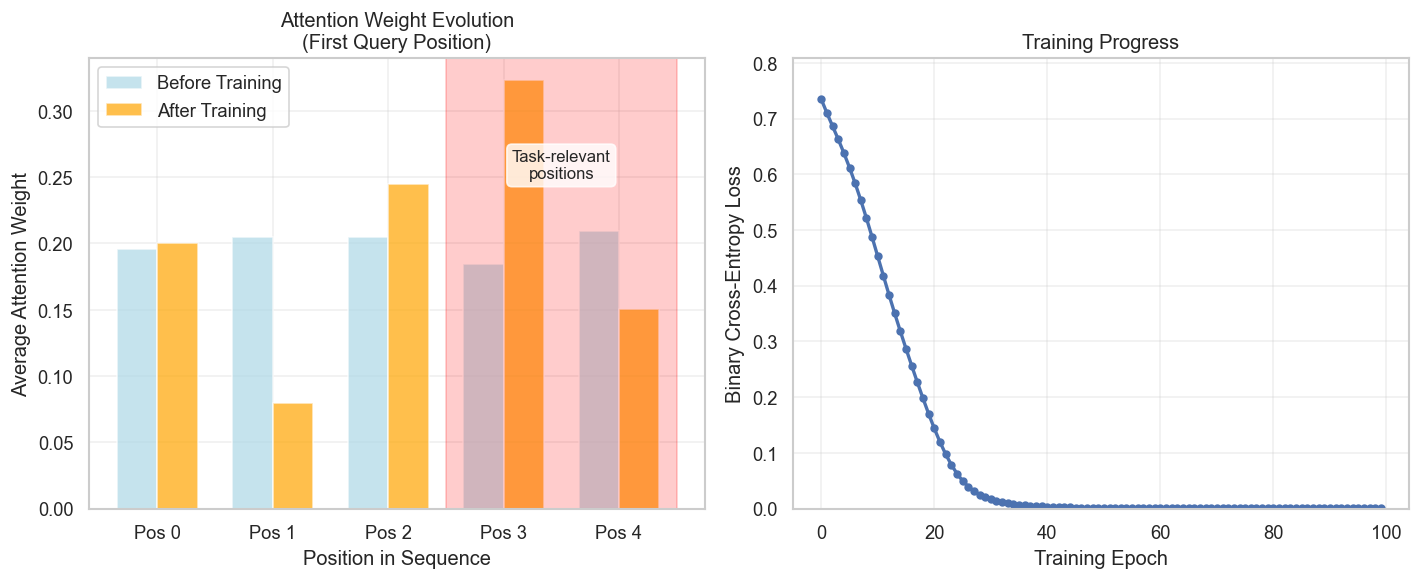


=== Analysis of Attention Shift ===
Attention weights before training: [0.19608454 0.2049479  0.20500572 0.184324   0.20963785]
Attention weights after training:  [0.20056483 0.07991013 0.24503851 0.32364947 0.15083705]

Change in attention to last two positions:
Position 3: 0.184 → 0.324 (Δ = +0.139)
Position 4: 0.210 → 0.151 (Δ = -0.059)


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

print("\n=== Section 2.5: Training and Backpropagation on Attention ===")
print("Demonstrating how attention weights evolve during training...\n")

# Create a tiny synthetic attention task
class TinyAttentionModel(nn.Module):
    def __init__(self, seq_len=5, embed_dim=16):
        super().__init__()
        self.embed_dim = embed_dim
        self.seq_len = seq_len
        # Simple attention mechanism
        self.query_proj = nn.Linear(embed_dim, embed_dim)
        self.key_proj = nn.Linear(embed_dim, embed_dim)
        self.value_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, 1)  # Final prediction

    def forward(self, x):
        # x shape: (batch, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = x.shape

        # Compute Q, K, V
        Q = self.query_proj(x)  # (batch, seq_len, embed_dim)
        K = self.key_proj(x)   # (batch, seq_len, embed_dim)
        V = self.value_proj(x)  # (batch, seq_len, embed_dim)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(embed_dim)
        attention_weights = F.softmax(scores, dim=-1)  # (batch, seq_len, seq_len)

        # Apply attention to values
        attended = torch.matmul(attention_weights, V)  # (batch, seq_len, embed_dim)

        # Global average pooling and prediction
        pooled = attended.mean(dim=1)  # (batch, embed_dim)
        output = self.out_proj(pooled)  # (batch, 1)

        return output, attention_weights

# Set random seed for reproducible results
torch.manual_seed(42)
np.random.seed(42)

# Create model and synthetic data
seq_len, embed_dim, batch_size = 5, 16, 20
model = TinyAttentionModel(seq_len=seq_len, embed_dim=embed_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Create synthetic training data
# Task: predict if the sum of the last two positions > threshold
X = torch.randn(batch_size, seq_len, embed_dim)
# Create target based on a pattern in the last two positions
target_pattern = X[:, -2:, :].mean(dim=(1, 2))  # Average of last two positions
y = (target_pattern > 0).float().unsqueeze(1)  # Binary classification

print(f"Created synthetic dataset:")
print(f"- Input shape: {X.shape}")
print(f"- Target shape: {y.shape}")
print(f"- Task: Predict if average of last 2 positions > 0\n")

# Record attention weights before training
with torch.no_grad():
    _, attn_before = model(X)
    # Average attention weights across batch and take first query position
    attn_before_avg = attn_before.mean(0)[0].detach().numpy()  # (seq_len,)

print("Starting training loop...")
losses = []

# Lightweight training loop (100 iterations)
for epoch in range(100):
    optimizer.zero_grad()

    # Forward pass
    output, attention_weights = model(X)

    # Compute loss
    loss = F.binary_cross_entropy_with_logits(output, y)

    # Backward pass
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 5 == 0:
        print(f"Epoch {epoch:2d}: Loss = {loss.item():.4f}")

# Record attention weights after training
with torch.no_grad():
    _, attn_after = model(X)
    attn_after_avg = attn_after.mean(0)[0].detach().numpy()  # (seq_len,)

print(f"\nTraining completed! Final loss: {losses[-1]:.4f}")
print(f"Loss improvement: {losses[0]:.4f} → {losses[-1]:.4f}\n")

# Plot attention weights before and after training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Attention weight evolution
positions = np.arange(seq_len)
width = 0.35

ax1.bar(positions - width/2, attn_before_avg, width, label='Before Training', alpha=0.7, color='lightblue')
ax1.bar(positions + width/2, attn_after_avg, width, label='After Training', alpha=0.7, color='orange')
ax1.set_xlabel('Position in Sequence')
ax1.set_ylabel('Average Attention Weight')
ax1.set_title('Attention Weight Evolution\n(First Query Position)')
ax1.set_xticks(positions)
ax1.set_xticklabels([f'Pos {i}' for i in positions])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Highlight that attention should focus more on last positions
ax1.axvspan(2.5, 4.5, alpha=0.2, color='red', label='Target Positions')
ax1.text(3.5, max(attn_after_avg) * 0.8, 'Task-relevant\npositions',
         ha='center', va='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Training loss curve
ax2.plot(losses, 'b-', linewidth=2, marker='o', markersize=4)
ax2.set_xlabel('Training Epoch')
ax2.set_ylabel('Binary Cross-Entropy Loss')
ax2.set_title('Training Progress')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, max(losses) * 1.1)

plt.tight_layout()
plt.show()

# Print analysis
print("\n=== Analysis of Attention Shift ===")
print(f"Attention weights before training: {attn_before_avg}")
print(f"Attention weights after training:  {attn_after_avg}")
print(f"\nChange in attention to last two positions:")
print(f"Position 3: {attn_before_avg[3]:.3f} → {attn_after_avg[3]:.3f} (Δ = {attn_after_avg[3] - attn_before_avg[3]:+.3f})")
print(f"Position 4: {attn_before_avg[4]:.3f} → {attn_after_avg[4]:.3f} (Δ = {attn_after_avg[4] - attn_before_avg[4]:+.3f})")


## 3 Using Pre-trained Transformer-based Language Models

### 3.1 Loading and Using Pre-trained BERT
BERT (Bidirectional Encoder Representations from Transformers) revolutionized natural language processing by introducing bidirectional attention mechanisms. This allows the model to understand context from both directions in a sentence.

Switch from toy tensors to a state-of-the-art language model without extra training.

Learning: Tokenisation workflow, pooled vs. per-token embeddings, and how transfer learning saves compute.

In [21]:
# ───────────────────────────  Section 3.1  (detailed)  ───────────────────────────
from transformers import AutoTokenizer, AutoModel
import torch, pandas as pd, numpy as np

sentence   = globals().get("example_text",
                           "I love learning Artificial Intelligence")
model_name = "bert-base-uncased"

tokenizer  = AutoTokenizer.from_pretrained(model_name)
bert       = AutoModel.from_pretrained(model_name, output_attentions=True,
                                       output_hidden_states=True)

# 1) Encode sentence → IDs, masks, etc.
batch = tokenizer(sentence, return_tensors="pt")
print("Token IDs:", batch["input_ids"][0].tolist())
print("Tokens   :", tokenizer.convert_ids_to_tokens(batch["input_ids"][0]), "\n")

# 2) Forward pass (no gradients)
with torch.no_grad():
    output = bert(**batch)

# ------------------------------------------------------------
# A. Last hidden state (per-token contextual embeddings)
# ------------------------------------------------------------
last = output.last_hidden_state      # (1, seq_len, hidden_dim)
print("last_hidden_state shape :", list(last.shape),
      "→ one 768-D vector for every token\n")

# B. Pooled output (CLS summary)
if hasattr(output, "pooler_output") and output.pooler_output is not None:
    pooled = output.pooler_output    # (1, hidden_dim)
    print("pooler_output shape     :", list(pooled.shape),
          "→ sentence-level vector used for classification\n")

# C. Hidden-state evolution table
depth = len(output.hidden_states)    # 13 (emb + 12 layers)
col_names = [f"L{i}" for i in range(depth)]
dims = [hs.std().item() for hs in output.hidden_states]     # variability proxy
df = pd.DataFrame([dims], columns=col_names, index=["Std-dev"])
display(df.style.format("{:.4f}").set_caption(
    "Feature variation across layers – grows as context is built"))

# D. Attention-saturation snapshot (last layer, head-wise)
att = output.attentions[-1][0]       # (heads, seq_len, seq_len)
self_focus = att.diagonal(dim1=-2, dim2=-1).mean(-1)        # mean of diagonals
print("\nHead-wise self-focus (last layer):",
      np.round(self_focus.numpy(), 3).tolist(),
      "→ how much each head looks at the same token")

# E. Quick glossary
print("""
Glossary:
• last_hidden_state  – contextual embedding for every token (used in most tasks).
• pooler_output      – CLS vector after tanh; common for sentence-level tasks.
• hidden_states      – all 13 layers (embedding + 12 encoder blocks); ideal for
                       probing / layer-wise visualisations.
• attentions         – 12 × 12 matrices (heads × layers) showing query↔key focus.
""")


Token IDs: [101, 1045, 2293, 4083, 7976, 4454, 102]
Tokens   : ['[CLS]', 'i', 'love', 'learning', 'artificial', 'intelligence', '[SEP]'] 

last_hidden_state shape : [1, 7, 768] → one 768-D vector for every token

pooler_output shape     : [1, 768] → sentence-level vector used for classification



,L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
Std-dev,0.5699,0.6427,0.6976,0.6774,0.6928,0.7107,0.7296,0.7012,0.6391,0.5716,0.6110,0.5997,0.5225



Head-wise self-focus (last layer): [0.1850000023841858, 0.17900000512599945, 0.21199999749660492, 0.1679999977350235, 0.1940000057220459, 0.3400000035762787, 0.21400000154972076, 0.17000000178813934, 0.5410000085830688, 0.2919999957084656, 0.18000000715255737, 0.17599999904632568] → how much each head looks at the same token

Glossary:
• last_hidden_state  – contextual embedding for every token (used in most tasks).
• pooler_output      – CLS vector after tanh; common for sentence-level tasks.
• hidden_states      – all 13 layers (embedding + 12 encoder blocks); ideal for
                       probing / layer-wise visualisations.
• attentions         – 12 × 12 matrices (heads × layers) showing query↔key focus.



### 3.2 Analyzing BERT Attention Patterns

Extract attention weights from a specific layer/head and plot them.

Learning: Real-world attention behaviour.

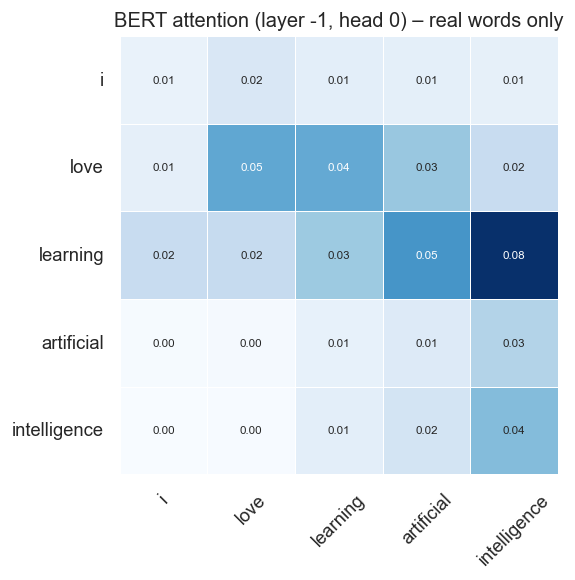

,Word,Avg attention received
0,i,0.010
1,love,0.018
2,learning,0.022
3,artificial,0.026
4,intelligence,0.036


/var/folders/pk/h07m6v012ps6xqkzqbccl6ym0000gn/T/ipykernel_73179/1329642213.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Word", y="Avg attention received", data=table, palette="Blues_d")


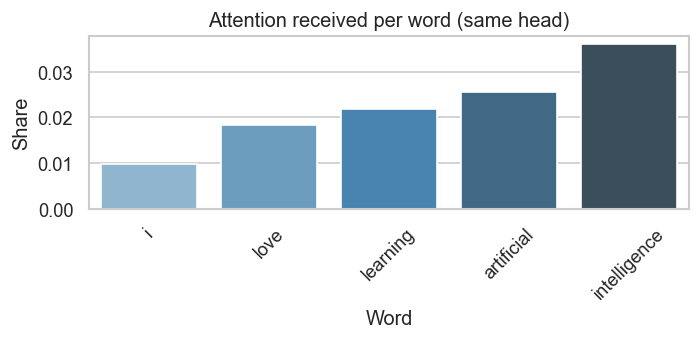

In [22]:
# ─────────── Section 3.2  (no CLS/SEP) ────────────
from transformers import AutoTokenizer, AutoModel
import torch, matplotlib.pyplot as plt, seaborn as sns, pandas as pd

sentence   = globals().get("example_text",
                           "I love learning Artificial Intelligence")
model_id   = "bert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(model_id)
bert       = AutoModel.from_pretrained(model_id, output_attentions=True)

tokens = tokenizer(sentence, return_tensors="pt")
with torch.no_grad():
    output = bert(**tokens)

# --------------------------------------------------
# 1) Strip CLS/SEP positions from everything
# --------------------------------------------------
# mapping from full-length indices → positions without CLS/SEP
# full tokens: [CLS] I love learning Artificial Intelligence [SEP]
all_toks = tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])
keep_idx = [i for i, tok in enumerate(all_toks) if tok not in ("[CLS]", "[SEP]")]
words    = [all_toks[i] for i in keep_idx]                # ['i', 'love', 'learning', 'artificial', 'intelligence']

layer, head = -1, 0                                        # last layer, first head
att_full = output.attentions[layer][0, head]               # (L_full, L_full)

# slice out rows & columns that correspond to real words
att = att_full[keep_idx][:, keep_idx]                      # (L_words, L_words)

# --------------------------------------------------
# 2) Heat-map (same as before but words-only)
# --------------------------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(att.numpy(), cmap="Blues",
            xticklabels=words, yticklabels=words,
            linewidths=.4, square=True, cbar=False,
            annot=True, fmt=".2f", annot_kws={"size":7})
plt.title(f"BERT attention (layer {layer}, head {head}) – real words only")
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

# --------------------------------------------------
# 3) “How-much-looked-at” table (words-only)
# --------------------------------------------------
received = att.mean(0)                                     # mean over query rows
table = pd.DataFrame({"Word": words,
                      "Avg attention received": received.numpy()})

display(table.style.format({"Avg attention received": "{:.3f}"}))

# --------------------------------------------------
# 4) Bar chart summary (optional eye-catch)
# --------------------------------------------------
plt.figure(figsize=(6,3))
sns.barplot(x="Word", y="Avg attention received", data=table, palette="Blues_d")
plt.title("Attention received per word (same head)")
plt.xticks(rotation=45); plt.ylabel("Share"); plt.tight_layout(); plt.show()


### 3.3 Comparing Different Transformer Models

Quickly probe different Transformer variants under the same input.

Learning: How architecture size and pre-training choices affect embedding shapes and resource use.

In [23]:
# ────────────────────── Section 3.3  (detailed) ──────────────────────
from transformers import AutoTokenizer, AutoModel
import torch, pandas as pd, time

sentence   = globals().get("example_text",
                           "I love learning Artificial Intelligence")
models_to_compare = [
    "bert-base-uncased",
    "distilbert-base-uncased",
    "roberta-base"
]

rows = []
print("Running inference …\n")

for name in models_to_compare:
    t0 = time.time()
    tok   = AutoTokenizer.from_pretrained(name)
    if "roberta" in name:
        model = AutoModel.from_pretrained(name, add_pooling_layer=False)
    else:
        model = AutoModel.from_pretrained(name)

    # one forward pass to measure speed & get embedding shape
    ids = tok(sentence, return_tensors="pt")
    with torch.no_grad():
        out = model(**ids)
    elapsed = time.time() - t0          # ← numeric value
    rows.append({
        "Model"        : name,
        "# layers"     : model.config.num_hidden_layers,
        "Hidden dim"   : model.config.hidden_size,
        "Tokens (prod)": len(ids["input_ids"][0]),
        "Params (M)"   : round(model.num_parameters() / 1e6, 1),
        "Forward (s)"  : elapsed          # keep as float
    })


# --------------------------- pretty table ----------------------------
df = pd.DataFrame(rows).set_index("Model")
display(df.style.format({
    "Params (M)" : "{:.1f}",
    "Forward (s)": "{:.3f}"
}))


# ---------------------- quick, human-readable notes -------------------
print("\nKey points you should notice:")

for r in rows:
    print(f"\n• {r['Model']}:")
    print(f"   - {r['# layers']} layers, hidden size {r['Hidden dim']}")
    print(f"   - {r['Tokens (prod)']} word-pieces for this sentence")
    print(f"   - {r['Params (M)']} M parameters → relative model size")
    print(f"   - {r['Forward (s)']:.3f} s to run the sentence once")


Running inference …



,# layers,Hidden dim,Tokens (prod),Params (M),Forward (s)
Model,,,,,
bert-base-uncased,12,768,7,109.5,1.299
distilbert-base-uncased,6,768,7,66.4,1.200
roberta-base,12,768,7,124.1,1.872



Key points you should notice:

• bert-base-uncased:
   - 12 layers, hidden size 768
   - 7 word-pieces for this sentence
   - 109.5 M parameters → relative model size
   - 1.299 s to run the sentence once

• distilbert-base-uncased:
   - 6 layers, hidden size 768
   - 7 word-pieces for this sentence
   - 66.4 M parameters → relative model size
   - 1.200 s to run the sentence once

• roberta-base:
   - 12 layers, hidden size 768
   - 7 word-pieces for this sentence
   - 124.1 M parameters → relative model size
   - 1.872 s to run the sentence once
